In [1]:
from IPython import get_ipython
import gin
gin.enter_interactive_mode()

# Enable autoreload
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

In [2]:
import sys 

sys.path.append("..")

In [3]:
from after.diffusion.networks import DenoiserV2

In [4]:
gin_config = "/Users/demerle/Documents/PHD/repos/AFTER/after/diffusion/configs/dummy.gin"

gin.parse_config_file(gin_config)

ParsedConfigFileIncludesAndImports(filename='/Users/demerle/Documents/PHD/repos/AFTER/after/diffusion/configs/dummy.gin', imports=['__gin__.dynamic_registration', 'after', 'after.diffusion', 'cached_conv.convs'], includes=[])

In [5]:
net = DenoiserV2()

In [104]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def get_relativistic_losses(score_real, score_fake):
    diff = score_real - score_fake
    dis_loss = F.softplus(-diff).mean()
    gen_loss = F.softplus(diff).mean()
    return dis_loss, gen_loss

class AdaLN(nn.Module):
    def __init__(self, normalized_shape, cond_dim, time_cond_dim):
        super().__init__()
        self.norm = nn.GroupNorm(num_groups=32, num_channels=normalized_shape)

        self.has_cond = cond_dim > 0
        self.has_time_cond = time_cond_dim > 0

        if self.has_cond:
            self.cond_proj = nn.Linear(cond_dim, 2 * normalized_shape)
        if self.has_time_cond:
            self.time_cond_proj = nn.Conv1d(time_cond_dim, 2 * normalized_shape, kernel_size=1)
            self.time_cond_downscale = nn.Conv1d(time_cond_dim,  time_cond_dim, kernel_size=3, stride = 2, padding = 1)

    def forward(self, x, cond=None, time_cond=None):
        # x: (B, C, T)
        x_normed = self.norm(x)

        scale = torch.ones_like(x_normed)
        shift = torch.zeros_like(x_normed)

        if self.has_cond and cond is not None:
            cond_affine = self.cond_proj(cond).unsqueeze(-1)  # (B, 2C, 1)
            c_scale, c_shift = cond_affine.chunk(2, dim=1)
            scale += c_scale
            shift += c_shift

        if self.has_time_cond and time_cond is not None:
            print(time_cond.shape)
            time_cond = self.time_cond_downscale(time_cond)
            time_affine = self.time_cond_proj(time_cond)  # (B, 2C, T)
            t_scale, t_shift = time_affine.chunk(2, dim=1)
            scale += t_scale
            shift += t_shift

        return x_normed * scale + shift, time_cond
    
    
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, norm = None):
        super().__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.norm = norm
        self.act = nn.SiLU()

    def forward(self, x, time_cond, cond):
        x = self.conv(x)
        if isinstance(self.norm, AdaLN):
            # If AdaLN, pass time_cond and cond
            x, time_cond = self.norm(x, cond=cond, time_cond=time_cond)
        else:   
            x = self.norm(x)
        x = self.act(x)
        return x, time_cond

class ConvDiscriminator(nn.Module):
    def __init__(
        self,
        in_channels,
        channels=64,
        num_layers=4,
        kernel_size=4,
        stride=2,
        padding=1,
        loss_type="lsgan",
        soft_clip_scale=None,
        channels_time_cond=0,
        channels_cond=0,
        cond_layers=None,
    ):
        super().__init__()
        self.loss_type = loss_type
        self.soft_clip_scale = soft_clip_scale
        self.cond_layers = cond_layers or num_layers  # default: apply to all

        self.cond_modules = nn.ModuleList()
        layers = []
        current_channels = in_channels

        for i in range(num_layers):
            
            if i < self.cond_layers and (channels_time_cond > 0 or channels_cond > 0):
                norm = AdaLN(channels, cond_dim=channels_cond, time_cond_dim=channels_time_cond)
            else:
                norm = nn.GroupNorm(num_groups=32, num_channels=channels)

            layers.append(ConvBlock(in_channels=current_channels,
                                    out_channels=channels,
                                    kernel_size=kernel_size,
                                    stride=stride,
                                    padding=padding,
                                    norm = norm))
            current_channels = channels
            

        # Final projection
        self.out_projection = nn.Conv1d(current_channels, 1, kernel_size=kernel_size, stride=1, padding=0)

        self.layers = nn.ModuleList(layers)

    def forward(self, x, cond=None, time_cond=None):
        
        
        for block in self.layers:
            x, time_cond  = block(x, time_cond, cond)
        
        return self.out_projection(x)


    def loss(self, reals, fakes, cond_reals=None, time_cond_reals=None, cond_fakes=None, time_cond_fakes=None):
        real_scores = self(reals, cond=cond_reals, time_cond=time_cond_reals)
        fake_scores = self(fakes, cond=cond_fakes, time_cond=time_cond_fakes)

        if self.loss_type == "lsgan":
            loss_dis = torch.mean(fake_scores ** 2) + torch.mean((1 - real_scores) ** 2)
            loss_adv = torch.mean((1 - fake_scores) ** 2)
        elif self.loss_type == "relativistic":
            loss_dis, loss_adv = get_relativistic_losses(real_scores, fake_scores)
        else:
            raise ValueError(f"Unsupported loss type: {self.loss_type}")

        return {
            "loss_dis": loss_dis,
            "loss_adv": loss_adv
        }
        
        
class LatentDiscriminator(nn.Module):
    def __init__(self, discriminator_head, pretrained_net):
        super().__init__()
        self.pretrained_net = pretrained_net
        self.discriminator = discriminator_head
        
    def loss(self, reals, fakes, time, cond_reals=None, time_cond_reals=None, cond_fakes=None, time_cond_fakes=None):
        
        reals = self.pretrained_net(x = reals, time = time, cond=cond_reals, time_cond = time_cond_reals)
        fakes = self.pretrained_net(x = fakes, time = time, cond = cond_fakes, time_cond = time_cond_fakes)
        
        losses = self.discriminator.loss(reals, fakes, cond_reals=cond_reals, time_cond_reals=time_cond_reals,cond_fakes=cond_fakes, time_cond_fakes=time_cond_fakes)
        return losses

In [100]:
net = DenoiserV2().eval()
net2 = DenoiserV2(n_layers = 4, use_out_proj=False).eval()
net2.load_state_dict(net.state_dict(), strict = False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['denoiser_trans_block.decoder_blocks.4.self_attention.qkv_linear.weight', 'denoiser_trans_block.decoder_blocks.4.self_attention.mha.rotary_emb.freqs', 'denoiser_trans_block.decoder_blocks.4.self_attention.rotary_emb.freqs', 'denoiser_trans_block.decoder_blocks.4.mlp.mlp.0.weight', 'denoiser_trans_block.decoder_blocks.4.mlp.mlp.0.bias', 'denoiser_trans_block.decoder_blocks.4.mlp.mlp.2.weight', 'denoiser_trans_block.decoder_blocks.4.mlp.mlp.2.bias', 'denoiser_trans_block.decoder_blocks.4.norm1.weight', 'denoiser_trans_block.decoder_blocks.4.norm1.bias', 'denoiser_trans_block.decoder_blocks.4.norm3.weight', 'denoiser_trans_block.decoder_blocks.4.norm3.bias', 'denoiser_trans_block.decoder_blocks.4.linear.weight', 'denoiser_trans_block.decoder_blocks.4.linear.bias', 'denoiser_trans_block.decoder_blocks.4.tcond_linear.weight', 'denoiser_trans_block.decoder_blocks.4.tcond_linear.bias', 'denoiser_trans_block.decoder_blocks.5.self_attention.qk

In [101]:
x = torch.randn((1, 64, 128))

time_cond = torch.randn((1, 12, 128))
cond = torch.randn((1, 6))
time = torch.randn((1))

y = net(x, time = time, time_cond = time_cond, cond = cond)
y2 = net2(x, time = time, time_cond = time_cond, cond = cond)

print(y.shape)
print(y2.shape)

# print((y-y2).max())

torch.Size([1, 64, 128])
torch.Size([1, 512, 128])


In [108]:
discriminator_head = ConvDiscriminator(
    in_channels=512,
    channels=512,
    num_layers=4,
    kernel_size=4,
    stride=2,
    padding=1,
    loss_type="relativistic",
    channels_cond = 6,
    channels_time_cond = 12,
    cond_layers = 2
)

allp = 0
for p in discriminator_head.parameters():
    allp += p.numel()
print(f"Discriminator params: {allp/1e6}")


pred = discriminator_head(y2)

discriminator_head.loss(y2, y2, cond_reals=cond, time_cond_reals=time_cond,cond_fakes=cond, time_cond_fakes=time_cond,)

Discriminator params: 4.244345
torch.Size([1, 12, 128])
torch.Size([1, 12, 64])
torch.Size([1, 12, 128])
torch.Size([1, 12, 64])


{'loss_dis': tensor(0.6931, grad_fn=<MeanBackward0>),
 'loss_adv': tensor(0.6931, grad_fn=<MeanBackward0>)}

In [92]:
discriminator = LatentDiscriminator(discriminator_head=discriminator_head, pretrained_net = net2)

discriminator.loss(x, torch.randn_like(x), time, cond_reals=cond, time_cond_reals=time_cond, cond_fakes=cond, time_cond_fakes=time_cond,)

{'loss_dis': tensor(0.6631, grad_fn=<MeanBackward0>),
 'loss_adv': tensor(0.7331, grad_fn=<MeanBackward0>)}

In [109]:
def sample_pgen(num_samples):
    """
    Uniform in log-SNR space from -6 to 2, mapped back to t-space [0, 1]
    """
    logsnr_min, logsnr_max = -6, 2
    logsnr = torch.rand(num_samples) * (logsnr_max - logsnr_min) + logsnr_min
    return logsnr  # or convert to t if needed



In [110]:
def sample_pdisc(num_samples, mu=0.0, sigma=1.0):
    """
    Samples from the shifted logit-normal distribution.
    Returns values in (0, 1).
    """
    normal = torch.randn(num_samples) * sigma + mu
    s = torch.sigmoid(normal)
    return s

def sample_pgen(num_samples, max_logsnr=2, min_logsnr = -5):
    t = 1-torch.sigmoid(-(torch.rand(num_samples) * (max_logsnr - min_logsnr) + min_logsnr))
    return t


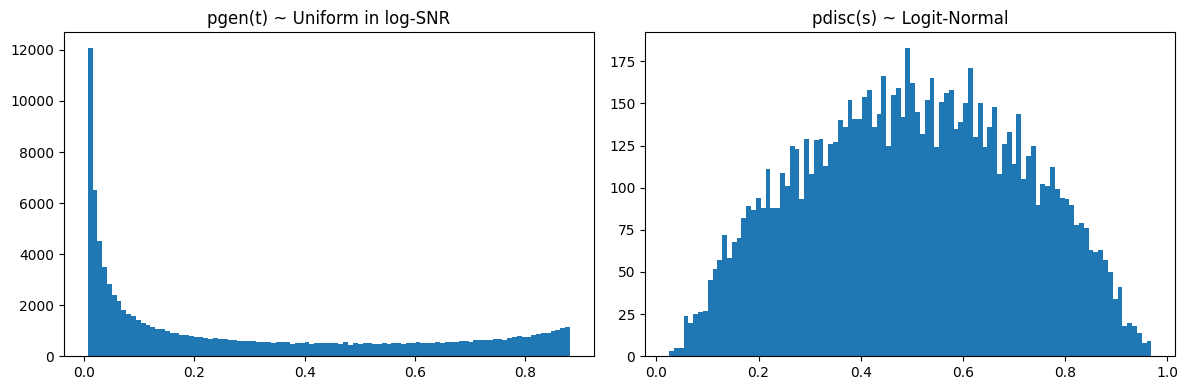

In [132]:
import matplotlib.pyplot as plt

t = sample_pgen(100000)
s = sample_pdisc(10000, mu=0.0, sigma=1.0)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(t.numpy(), bins=100)
plt.title("pgen(t) ~ Uniform in log-SNR")

plt.subplot(1, 2, 2)
plt.hist(s.numpy(), bins=100)
plt.title("pdisc(s) ~ Logit-Normal")

plt.tight_layout()
plt.show()
